# Wind farm clusters

In some cases, you are only interested in the performance of your own wind farm, but want to include wake and blockage effects from neighbouring wind farm clusters. If the neighbouring farms contains many wind turbines, the simulation can be very slow and memory demanding. These issues can be reduced by modelling the neighbouring wind farm clusters using the external wind farm model approach. Different external wind farm models exist with varying amount of precomputation.

Import modules

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from numpy import newaxis as na
from tqdm import tqdm
from py_wake.deficit_models import BastankhahGaussianDeficit, SelfSimilarityDeficit2020
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.flow_map import XYGrid, Points, Grid
from py_wake.site.streamline_distance import StreamlineDistance
from py_wake.superposition_models import LinearSum
from py_wake.utils import layouts
from py_wake.utils.plotting import setup_plot
from py_wake.utils.profiling import profileit, timeit
from py_wake.utils.streamline import VectorField3D
from py_wake.wind_farm_models import PropagateDownwind, All2AllIterative
from py_wake.wind_farm_models.external_wind_farm_models import ExternalWFMWindFarm, ExternalXRRelWindFarm, ExternalXRAbsWindFarm
from py_wake.wind_turbines import WindTurbines

Setup site, wind turbines and wind farm positions

In [2]:
windTurbines = WindTurbines.from_WindTurbine_lst([V80()]*6)
windTurbines._names = ["Current WF"] + [f"WF{i+1}" for i in np.arange(5)]

# setup current, neighbour and all positions
wf_x, wf_y = layouts.circular([1, 5, 12, 18], 1800)
H, D = windTurbines.hub_height(), windTurbines.diameter()

No_neighbours = 5
if Grid.default_resolution==100:
    wf_x, wf_y = wf_x[:18], wf_y[:18]
    No_neighbours = 1
neighbour_x_y_angle = [(wf_x+6000*np.cos(d), wf_y+6000*np.sin(d), (90-np.rad2deg(d))%360) 
                       for d in np.linspace(0,2*np.pi, No_neighbours, endpoint=False)]
neighbour_x, neighbour_y,_ = zip(*neighbour_x_y_angle)

all_x, all_y = np.r_[wf_x,np.array(neighbour_x).flatten()], np.r_[wf_y,np.array(neighbour_y).flatten()]


types = [v for i in range(No_neighbours+1) for v in [i]*len(wf_x)]
ext = 500
grid = XYGrid(x=np.linspace(min(all_x) - ext, max(all_x) + ext, 100), y=np.linspace(min(all_y) - ext, max(all_y) + ext, 100), h=70)
fine_grid = XYGrid(x=np.linspace(min(all_x) - ext, max(all_x) + ext, 500), y=np.linspace(min(all_y) - ext, max(all_y) + ext, 500), h=70)

def get_wfm(externalWindFarms=[], wfm_cls=PropagateDownwind, site=Hornsrev1Site()):
    kwargs = dict(site=site, windTurbines=windTurbines,
                  wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                  superpositionModel=LinearSum(),
                  externalWindFarms=externalWindFarms)
    if wfm_cls==All2AllIterative:
        kwargs['blockage_deficitModel'] = SelfSimilarityDeficit2020()
    return wfm_cls(**kwargs)

wfm_ref = get_wfm()

def setup_ext_farms(cls, neighbour_x_y_angle, wfm=wfm_ref, include_wd_range=np.arange(-45,45)):
    ext_farms = []
    for i, (x, y, angle) in enumerate(neighbour_x_y_angle,1):
        wd_lst = (include_wd_range + angle) % 360 # relevant wind directions
        name = f'WF{i}'
        if cls is ExternalWFMWindFarm:
            ext_wf = ExternalWFMWindFarm(name, wfm, x, y, include_wd=wd_lst)
        elif cls is ExternalXRRelWindFarm:
            # Coarse grid in relative downwind, crosswind and vertical direction
            grid_xyh = (np.linspace(3000,9000, 20),
                        np.linspace(-3000,3000, 20),
                        np.array([0]))
            ext_wf = ExternalXRRelWindFarm.generate(name, grid_xyh, wfm, wt_x=x, wt_y=y, wd=wd_lst)
        elif cls is ExternalXRAbsWindFarm:
            # coarse grid in East, North and vertical direction covering the current wind farm
            grid_xyh = (np.linspace(wf_x.min() - 1000, wf_x.max() + 1000, 20),
                        np.linspace(wf_y.min() - 1000, wf_y.max() + 1000, 20),
                        np.array([H]))
            ext_wf = ExternalXRAbsWindFarm.generate(name, grid_xyh, wfm, wt_x=x, wt_y=y, wd=wd_lst)
        ext_farms.append(ext_wf)
    return ext_farms

df = pd.DataFrame({'AEP current WF [GWh]':[],'Time [s]':[],'Memory [MB]':[]})

Plot wind farm clusters used in this example. We are only interested in the AEP of `Current WF` but want to include wake effects from `WF1`-`WF6`

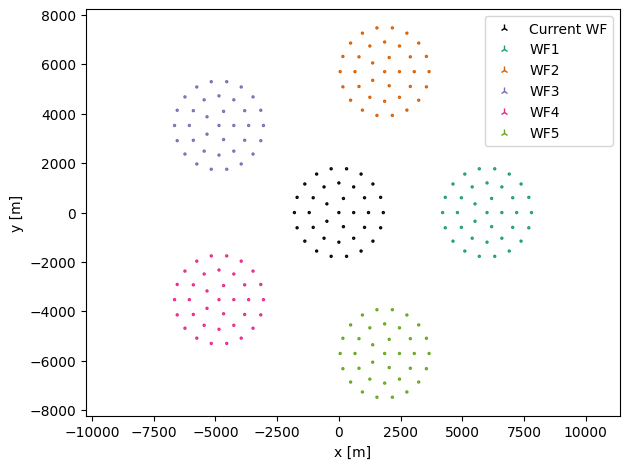

In [3]:
windTurbines.plot(all_x, all_y, type=types, wt_number=0)
setup_plot(axis='equal', grid=0, xlabel='x [m]', ylabel='y [m]')  

## Simulate all wind turbines
As a base line, we simulate all wind turbines and then select the AEP contributions from the current wind farm. This means that we need to simulate the wake interaction (only downwind in this case) between all 216 (6x36) wind turbines.

In [4]:
aep_all, t, mem = profileit(lambda : wfm_ref(all_x, all_y, type=types).aep().isel(wt=np.arange(len(wf_x))))()
df.loc['Simulating all WT'] = [aep_all.sum().item(), np.mean(t), mem]
np.round(df,2)

,AEP current WF [GWh],Time [s],Memory [MB]
Simulating all WT,302.92,24.0,1750.23


## Simulate current wind farm only
A faster, but incorrect alternative, is to calculate the AEP of the 36 wind turbines in the current wind farm without wake effects from the neighbouring wind farms

In [5]:
aep_wf, t, mem = profileit(lambda : wfm_ref(wf_x, wf_y, type=0).aep())()
df.loc['Simulating current WF only'] = [aep_wf.sum().item(), np.mean(t), mem]
np.round(df,2)

,AEP current WF [GWh],Time [s],Memory [MB]
Simulating all WT,302.92,24.00,1750.23
Simulating current WF only,311.35,0.75,67.38


As expected the AEP is higher in this case, because the wake effects from the neighbouring wind farms are neglected.

## Simulate using ExternalWindFarm model approach

The External wind farm model approach has the potential to speedup the simulation and lower the memory requirements.
In this approach, each external wind farm is considered as single wake sources, i.e. in the current setup, the number of wake sources is reduced from 216 (6*36) to 41 (36+5).

There are currently three ExternalWindFarm models:
- [External**WFM**WindFarm](ExternalWFMWindFarm) (everything computed during simulation)
- [External**XRRel**WindFarm](ExternalXRRelWindFarm) (Wake deficit precomputed and stored as xarray dataset in relative (downwind/crosswind) coordinates)
- [External**XRAbs**WindFarm](ExternalXRAbsWindFarm) (Wake deficit precomputed and stored as xarray dataset in absolute (East/North) coordinates)

For all models the performance can be improved by limiting the included wind directions, such that the wake is computed only for wind directions where the wake of the external WF affects the current WF.

### Setup External wind farm models
The time and memory used to setup the external wind farm models are shown below.

In [6]:
setup_df = pd.DataFrame({'Time [s]':[],'Memory [MB]':[]})
ext_wf_dict = {}
ext_cls_lst = [ExternalWFMWindFarm, ExternalXRAbsWindFarm, ExternalXRRelWindFarm]
for cls in ext_cls_lst:
    ext_farm_lst,t,mem = profileit(setup_ext_farms)(cls, neighbour_x_y_angle)
    ext_wf_dict[cls] = ext_farm_lst
    setup_df.loc[f'Setup {cls.__name__}'] = [np.mean(t), mem]
np.round(setup_df,1)

,Time [s],Memory [MB]
Setup ExternalWFMWindFarm,0.0,0.0
Setup ExternalXRAbsWindFarm,15.2,610.2
Setup ExternalXRRelWindFarm,18.7,47.2


Note, the time and memory usage of the `ExternalXRRelWindFarm` and `ExternalXRAbsWindFarm` are highly dependent on the grid resolution. In this case, the grid is very coarse and contains only one height (hub height)

In [7]:
# make animations for figures below
from matplotlib.animation import FuncAnimation, PillowWriter
def make_animation(cls):
    os.makedirs('images', exist_ok=True)
    fn = f'images/{cls.__name__}.gif'
    if os.path.isfile(fn):
        return
    with plt.ioff():
        fig, ax = plt.subplots()
        wd_lst = np.round(np.linspace(0,360,30, endpoint=False)).astype(int)
        wfm = get_wfm(ext_wf_dict[cls])
        sim_res = wfm([],[], ws=10)
        def animate(i):
            plt.cla()
            wd = wd_lst[i]
            sim_res.flow_map(fine_grid, wd=wd, ws=10).plot_wake_map(levels=np.linspace(6,10,21), plot_colorbar=False)
            windTurbines.plot(wf_x, wf_y, wt_number=0)
            plt.arrow(wf_x[0],wf_y[0], np.cos(np.deg2rad(270-wd))*2000, np.sin(np.deg2rad(270-wd))*2000, width=100)
            setup_plot(grid=False, title=f'{cls.__name__}, {wd} deg', axis='scaled')
            
        animation = FuncAnimation(fig, animate, frames=len(wd_lst))
        writergif = PillowWriter(fps=5)
        animation.save(fn, writer=writergif)
    plt.close()
for cls in tqdm(ext_cls_lst):
    make_animation(cls)    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 990.62it/s]


### ExternalWFMWindFarm
The `ExternalWFMWindFarm` does not precomputed anything so the setup is neglectable, but computing the wake from the external wind farm on the current wind turbines requires:
1. Determine the effective wind speed (actual wind speed including wakes) at the center of each external wind farm
2. Simulate each external WF, i.e. determine `CT` and `WS_eff` of each WT in the external WF
3. Compute the wake from each external WT on each WT in the current WF (using the flow map method).

Note, the `WindFarmModel`, used by `ExternalWFMWindFarm` to simulate the external wind farm wake, may be different than the `WindFarmModel` used to simulate wakes inside the current farm. 

<img src="images/ExternalWFMWindFarm.gif">

### ExternalXRRelWindFarm and ExternalXRAbsWindFarm
`ExternalXRRelWindFarm` and `ExternalXRAbsWindFarm` take a xarray dataset as input. The dataset should include the deficit as function of position, wind direction and wind speed. For `ExternalXRRelWindFarm`, the position is relative to the wind farm in downwind, horizonal crosswind and vertical direction, while the position for `ExternalXRAbsWindFarm` is absolute East, North and vertical coordinates. 
The deficit dataset can be generated using the `ExternalXRXXXWindFarm.generate` method or obtained from other tools.

The `ExternalXRXXXWindFarm.generate` method will:
1. Simulate external WF, i.e. determine `CT` and `WS_eff` of each WT in the external WF
2. Compute the wake from each external WT on each grid point using the flow map method.

Note, that the deficit dataset easily becomes huge and thereby memory demanding. With 100 points in x, y and h, 90 wind directions and 23 wind speeds, the size will be around 15Gb.

Simulating the wake from the external wind farm on the current wind turbines requires:
1. Determine the effective wind speed (actual wind speed including wakes) at the center of the external wind farm
1. Interpolate the precomputed deficit to obtain the deficit at the position of the WT in the current WF for the actual wind speed and direction

Typically, `ExternalXRRelWindFarm` requires fewer grid points than `ExternalXRAbsWindFarm` as the wakes are aligned with the downwind axis.
In both cases care must be taken to ensure that the grid covers the full area of interest.

<table>
    <tr>
        <td><img src="images/ExternalXRRelWindFarm.gif"></td>
        <td><img src="images/ExternalXRAbsWindFarm.gif"></td>
    </tr>
</table>

### Run external wind farm simulations

In [8]:
for cls in [ExternalWFMWindFarm, ExternalXRRelWindFarm, ExternalXRAbsWindFarm]:
    wfm = get_wfm(ext_wf_dict[cls])
    aep, t, mem = profileit(lambda : wfm(wf_x, wf_y, type=0).aep().isel(wt=np.arange(len(wf_x))))()
    df.loc[f'Simulating current + {cls.__name__}'] = [aep.sum().item(), np.mean(t), mem]
np.round(df,2)

,AEP current WF [GWh],Time [s],Memory [MB]
Simulating all WT,302.92,24.00,1750.23
Simulating current WF only,311.35,0.75,67.38
Simulating current + ExternalWFMWindFarm,302.92,39.45,85.44
Simulating current + ExternalXRRelWindFarm,302.90,1.62,82.13
Simulating current + ExternalXRAbsWindFarm,302.90,1.50,82.32


Note, the accuracy of the `ExternalXRRelWindFarm` and `ExternalXRAbsWindFarm` is highly dependent on the grid resolution used during setup.

## Cluster interaction

In some cases, the external wind farm model approach cannot model the AEP correctly.

In the example below, WF1 (green) is affected by WF2 (orange) 

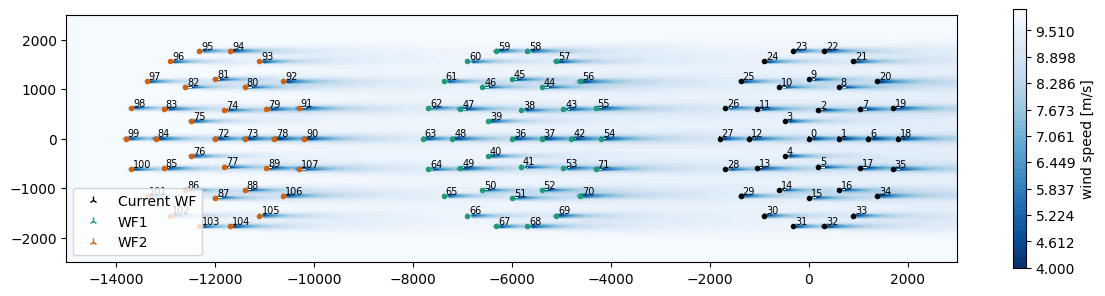

In [33]:
No_neighbours = 2
neighbour_x_y_angle = [(wf_x-6000*i, wf_y, 270) for i in range(1,No_neighbours+1)]
neighbour_x, neighbour_y,_ = zip(*neighbour_x_y_angle)
all_x, all_y = np.r_[wf_x,np.array(neighbour_x).flatten()], np.r_[wf_y,np.array(neighbour_y).flatten()]


types = [v for i in range(No_neighbours+1) for v in [i]*len(wf_x)]
wd = 270
wfm_ref = get_wfm()
sim_res_ref = wfm_ref(all_x, all_y, type=types, wd=wd, ws=10)

ext_farms = setup_ext_farms(ExternalWFMWindFarm, neighbour_x_y_angle)
wfm = get_wfm(ext_farms)
sim_res_ext = wfm(wf_x, wf_y, type=0, wd=wd,ws=10)

grid = XYGrid(x=np.linspace(-15000,3000,150), y=np.linspace(-2500,2500,100))
fm_ref = sim_res_ref.flow_map(grid)
fm_ref.plot_wake_map(levels=np.linspace(4,10,50))
setup_plot(grid=False, figsize=(12,3), axis='scaled')

When simulating all wind turbines, the inflow to all wind turbines in WF1 is calculated from the background flow and the position-dependent wake deficit from WF2, see left plot below.

In the external wind farm approach, on the other hand, WF1 is considered as one entity and the (uniform) inflow to the whole farm is computed from the effective wind speed at the center of the farm. From this wind speed, the operation of WF1 is simulated, see right plot below.

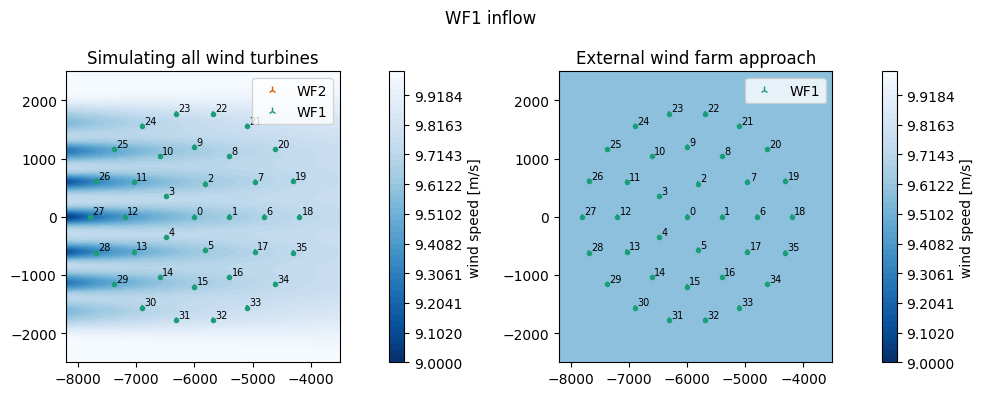

In [34]:
axes = plt.subplots(1,2, figsize=(10,4))[1]
sim_res_wf1_ref = wfm_ref(neighbour_x[1], neighbour_y[1], type=2, wd=wd,ws=10)
WF1_ws = sim_res_wf1_ref.flow_map(Points(-6000,0,70)).WS_eff.item()
sim_res_wf1 = get_wfm()([],[], type=2, wd=wd,ws=WF1_ws)

plt.suptitle('WF1 inflow')
for ax, sr, title in zip(axes, [sim_res_wf1_ref, sim_res_wf1], ['Simulating all wind turbines','External wind farm approach']):
    sr.flow_map(XYGrid(x=np.linspace(-8200,-3500,100), y=np.linspace(-2500,2500,100))).plot_wake_map(levels=np.linspace(9,10), ax=ax)
    windTurbines.plot(neighbour_x[0], neighbour_y[0], type=1, wd=270, ax=ax)
    setup_plot(grid=0, xlim=[-8200,-3500], axis='scaled', ax=ax, title=title)


This means that the wake deficit from WF1 will be slightly different, as seen below.

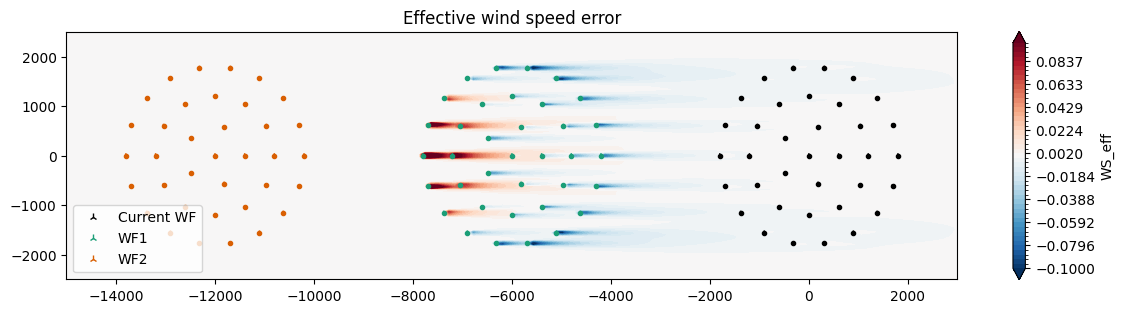

In [35]:
fm_ref = sim_res_ref.flow_map(grid)
fm = sim_res_ext.flow_map(grid)
(fm_ref.WS_eff - fm.WS_eff).squeeze().plot.contourf(levels=50, vmin=-.1, vmax=0.1, cmap='RdBu_r')

windTurbines.plot(all_x, all_y, type=types, wt_number=0, wd=wd)
setup_plot(axis='scaled', xlabel='', ylabel='', grid=0, title='Effective wind speed error', figsize=(12,3))

In this example, the error of the inflow to the Current WF is small and it produces almost the same amount of power:

In [36]:
df = pd.DataFrame({'Power current WF [MW]':[]})
df.loc['Simulating all WT'] = sim_res_ref.Power[:len(wf_x)].sum().item()
df.loc['Simulating current + external farms'] = sim_res_ext.Power[:len(wf_x)].sum().item()
np.round(df*1e-6,3)

,Power current WF [MW]
Simulating all WT,31.219
Simulating current + external farms,31.245


## Cluster blockage

Blockage is another interaction aspect that the external wind farm model approach cannot handle correct, but the typically the errors are negligible.

In the example below, WF1 (green) is affected by the blockage of the current wind farm (black)

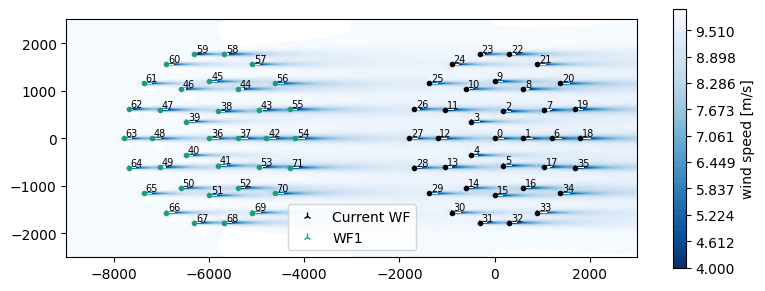

In [13]:
No_neighbours = 1
neighbour_x_y_angle = [(wf_x-6000*i, wf_y, 270) for i in range(1,No_neighbours+1)]
neighbour_x, neighbour_y,_ = zip(*neighbour_x_y_angle)
all_x, all_y = np.r_[wf_x,np.array(neighbour_x).flatten()], np.r_[wf_y,np.array(neighbour_y).flatten()]
types = [v for i in range(No_neighbours+1) for v in [i]*len(wf_x)]

wfm_ref = get_wfm(wfm_cls=All2AllIterative)
sim_res_ref = wfm_ref(all_x, all_y, type=types, wd=270,ws=10)

ext_farms = setup_ext_farms(ExternalWFMWindFarm, neighbour_x_y_angle, wfm=wfm_ref)
wfm = get_wfm(ext_farms, All2AllIterative)
sim_res_ext = wfm(wf_x, wf_y, type=0, wd=270,ws=10)

grid = XYGrid(x=np.linspace(-9000,3000,150), y=np.linspace(-2500,2500,200))
fm_ref = sim_res_ref.flow_map(grid)
plt.figure(figsize=(8,3))
fm_ref.plot_wake_map(levels=np.linspace(4,10,50))
setup_plot(grid=False, axis='scaled')

When simulating all wind turbines, the inflow to WF1 is calculated from the background flow and the position-dependent blockage deficit from the current WF, see left plot below.

In the external wind farm approach, on the other hand, WF1 is considered as one entity and the (uniform) inflow is computed from the effective wind speed at the center of the farm. From this wind speed, the operation of WF1 is simulated, see right plot below.

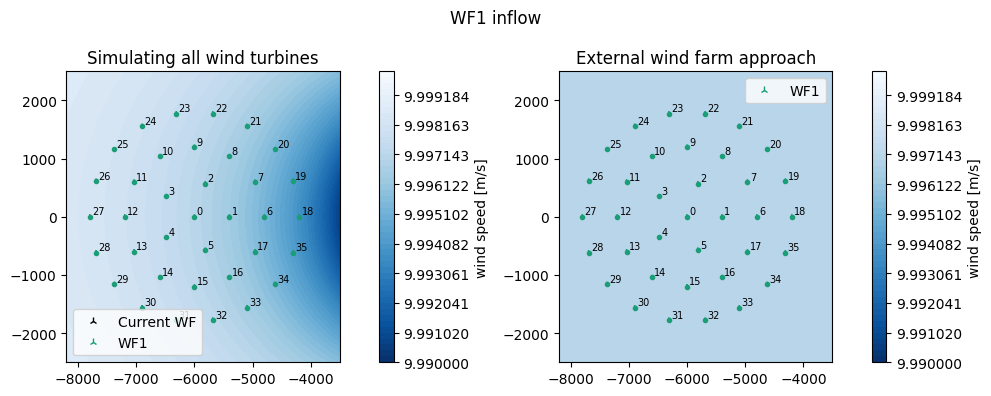

In [14]:
axes = plt.subplots(1,2, figsize=(10,4))[1]
sim_res_wf1_ref = wfm_ref(wf_x, wf_y, type=0, wd=270,ws=10)
WF1_ws = sim_res_wf1_ref.flow_map(Points(-6000,0,70)).WS_eff.item()
sim_res_wf1 = get_wfm()([],[], type=1, wd=270,ws=WF1_ws)

plt.suptitle('WF1 inflow')
for ax, sr, title in zip(axes, [sim_res_wf1_ref, sim_res_wf1], ['Simulating all wind turbines','External wind farm approach']):
    sr.flow_map(XYGrid(x=np.linspace(-8200,+3500,100), y=np.linspace(-2500,2500,100))).plot_wake_map(levels=np.linspace(9.99,10), ax=ax)
    windTurbines.plot(neighbour_x[0], neighbour_y[0], type=1, wd=270, ax=ax)
    setup_plot(grid=0, xlim=[-8200,-3500], axis='scaled', ax=ax, title=title)

This means that the wake deficit from WF1 will be slightly different, as seen below

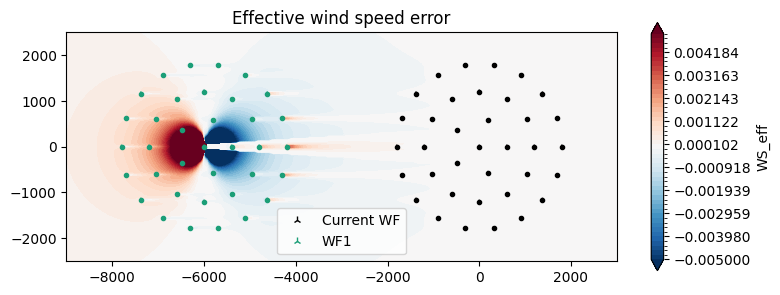

In [15]:
fm = sim_res_ext.flow_map(grid)
(fm_ref.WS_eff - fm.WS_eff).squeeze().plot.contourf(levels=50, vmin=-.005, vmax=0.005, cmap='RdBu_r')
windTurbines.plot(all_x, all_y, type=types, wt_number=0, wd=270)
setup_plot(axis='scaled', xlabel='', ylabel='', grid=0, title='Effective wind speed error', figsize=(8,3))

In [16]:
df = pd.DataFrame({'Power current WF [MW]':[]})
df.loc['Simulating all WT with blockage'] = sim_res_ref.Power[:len(wf_x)].sum().item()
df.loc['Simulating all WT without blockage'] = get_wfm()(all_x, all_y, wd=270,ws=10).Power[:len(wf_x)].sum().item()
df.loc['Simulating current + external farms with blockage'] = sim_res_ext.Power[:len(wf_x)].sum().item()
np.round(df*1e-6,3)

,Power current WF [MW]
Simulating all WT with blockage,32.607
Simulating all WT without blockage,32.616
Simulating current + external farms with blockage,32.608


## Clusters with streamlines
The external wind farm model approach can be combined with stream lines.

In the example below, the wind direction is set to 270 deg plus a x-dependent turning.

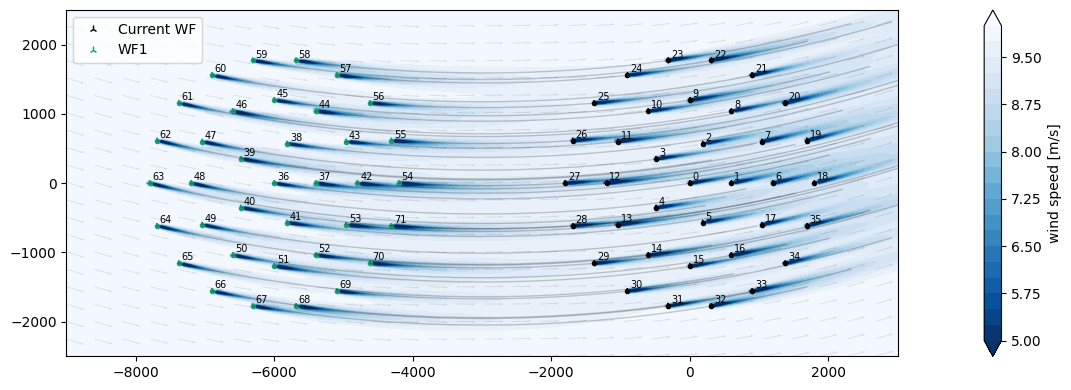

In [17]:
wf_x, wf_y = layouts.circular([1, 5, 12, 18], 1800)

class MyVectorField(VectorField3D):
    def __init__(self):
        pass 
        
    def __call__(self, wd, time, x, y, h):
        turning = (x+3000)/350
        theta = np.deg2rad(270 - wd + turning)
        return np.array([np.cos(theta), np.sin(theta), theta * 0]).T

vf3d = MyVectorField()
site = Hornsrev1Site()
site_with_streamlines = Hornsrev1Site()

site_with_streamlines.distance = StreamlineDistance(vf3d)

wfm_ref = get_wfm(site=site_with_streamlines)
No_neighbours = 1
neighbour_x_y_angle = (wf_x-6000, wf_y, 270)
neighbour_x, neighbour_y,_ = neighbour_x_y_angle
all_x, all_y = np.r_[wf_x,np.array(neighbour_x).flatten()], np.r_[wf_y,np.array(neighbour_y).flatten()]
types = [v for i in range(No_neighbours+1) for v in [i]*len(wf_x)]

grid = XYGrid(x=np.linspace(-9000,3000,150), y=np.linspace(-2500,2500,200))


sim_res_ref = wfm_ref(all_x, all_y, type=types, wd=270, ws=10)
df = pd.DataFrame({'Power current WF [MW]':[]})
df.loc['Simulating all WT'] = sim_res_ref.Power[:len(wf_x)].sum().item()

fm_ref = sim_res_ref.flow_map(grid)
fm_ref.plot_wake_map(levels=np.linspace(5,10,21))
X,Y = grid([],[], wfm_ref.windTurbines.hub_height())[:2]
X, Y = X[::10,::5],Y[::10,::5]
Vx,Vy,Vz = vf3d(270,None,X,Y,None).T

plt.quiver(X, Y, Vx, Vy, alpha=.1, width=.001)
stream_lines = vf3d.stream_lines(wd=np.full_like(neighbour_x,270), start_points=np.array([neighbour_x, neighbour_y, np.full_like(neighbour_x,70)]).T,
                                 dw_stop=np.full_like(neighbour_x, 8000))
for sl in stream_lines:
    plt.plot(sl[:, 0], sl[:, 1], 'k', lw=1, alpha=0.2)
    
setup_plot(axis='scaled', xlabel='', ylabel='', xlim=[-9000,3000], grid=0, figsize=(12,4))

When modelling `WF1` with the external wind farm model approach, there are two options:

1. Calculate the wake from each WT in `WF1` along their individual streamlines and let the WF wake (which already include streamlines) go straight to the `Current WF`.
2. Calculate the wake from each WT in `WF1` without streamlines and let the WF wake follow the streamline from the WF center

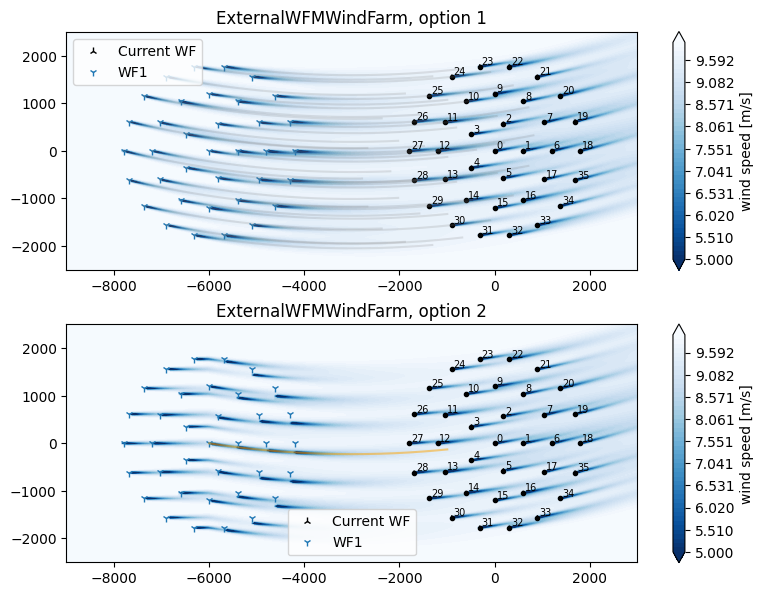

In [18]:
cls = ExternalWFMWindFarm
fig, axes = plt.subplots(2,1,figsize=(8,6))

for i, (ax, site_setup) in enumerate(zip(axes, [site_with_streamlines, site]), 1):
    # setup external wind farm model
    # - option 1: with streamlines
    # - option 2: without streamlines
    ext_farms = setup_ext_farms(cls, [neighbour_x_y_angle], wfm=get_wfm(site=site_setup), include_wd_range=np.array([0]))
    
    # Setup simulation using site with stream lines
    wfm = get_wfm(ext_farms, site=site_with_streamlines)
    sim_res_ext = wfm(wf_x, wf_y, type=0, wd=270, ws=10)
    df.loc[f'Simulating current + {cls.__name__}, option {i} '] = sim_res_ext.Power[:len(wf_x)].sum().item()

    
    fm = sim_res_ext.flow_map(grid)
    
    fm.plot_wake_map(ax=ax, levels=np.linspace(5,10))
    
    if site_setup==site_with_streamlines:
        start_points, alpha, c = np.array([ext_farms[0].wt_x, ext_farms[0].wt_y, ext_farms[0].wt_x*0+H]).T, 0.2, 'gray'
    else:
        start_points, alpha, c = np.array([[-6000., 0, 70]]), .5, 'orange'
    stream_lines = vf3d.stream_lines(wd=[270], start_points=start_points, dw_stop=np.full(start_points[:,0].shape, 5000))
    for sl in stream_lines:
        ax.plot(sl[:, 0], sl[:, 1], color=c, alpha=alpha)
        
    setup_plot(ax=ax, axis='scaled', xlabel='', ylabel='', title=f'{cls.__name__}, option {i}', grid=0)

With
- Option 1, the WT wakes follow the (correct) individual WT streamlines as in the reference result above, see left plot below, but the simulation is slightly slower than option 2. <br>It is possible to combine `ExternalXRRelWindFarm` and `ExternalXRAbsWindFarm` with option 1, if the precomputed deficit dataset can be computed with streamline. This is not alway possible and it will make the model less general.
- Option 2, the WF wake (computed without streamlines) follows the streamline starting at the WF center. This means that `WF1` operates as in uniform inflow from the West without streamlines and e.g. the four highlighed WT below operates in full wake condition. Furthermore, the wake is shifted downwards, such that the wake do not start at the generating WTs.

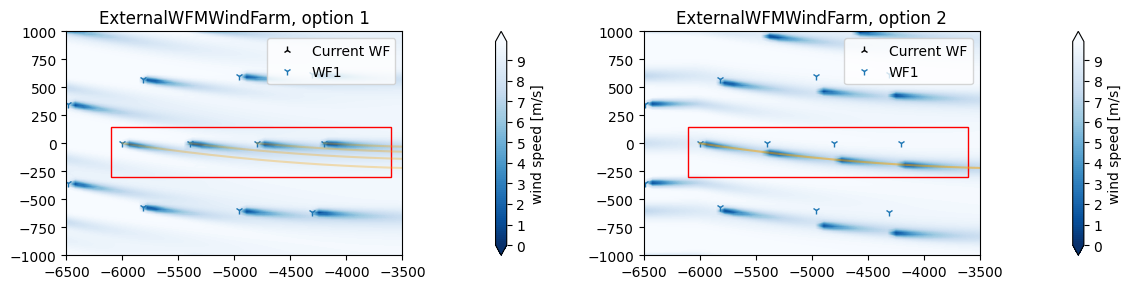

In [19]:
fig, axes = plt.subplots(1,2,figsize=(12,3))
for i, (ax, site_setup) in enumerate(zip(axes, [site_with_streamlines, site]), 1):
    ext_farms = setup_ext_farms(cls, [neighbour_x_y_angle], wfm=get_wfm(site=site_setup), include_wd_range=np.array([0]))
    
    wfm = get_wfm(ext_farms, site=site_with_streamlines)
    sim_res_ext = wfm(wf_x, wf_y, type=0, wd=270, ws=10)
    
    fm = sim_res_ext.flow_map(grid)
    
    fm.plot_wake_map(ax=ax)
    
    if site_setup==site_with_streamlines:
        idx=[0,1,6,18]
        #idx=slice(None)
        start_points, alpha = np.array([ext_farms[0].wt_x[idx], ext_farms[0].wt_y[idx], ext_farms[0].wt_x[idx]*0+H]).T, 0.3
    else:
        start_points, alpha = np.array([[-6000., 0, 70]]), .5
    stream_lines = vf3d.stream_lines(wd=[270], start_points=start_points, dw_stop=np.full(start_points[:,0].shape, 5000))
    for sl in stream_lines:
        ax.plot(sl[:, 0], sl[:, 1], color='orange', alpha=alpha)
        
    ax.add_patch(patches.Rectangle((-6100, -300), 2500, 450, linewidth=1, edgecolor='r', facecolor='none'))
    setup_plot(ax=ax, axis='scaled', xlabel='', ylabel='', xlim=[-6500, -3500], ylim=[-1000,1000], title=f'{cls.__name__}, option {i}', grid=0)

Using option 2, the inflow to `Current WF` and its power are therefore different as seen below

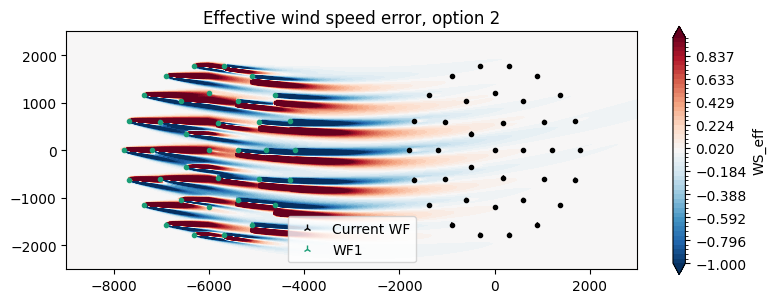

In [20]:
(fm_ref.WS_eff - fm.WS_eff).squeeze().plot.contourf(levels=50, vmin=-1, vmax=1, cmap='RdBu_r')
windTurbines.plot(all_x, all_y, type=types, wt_number=0, wd=270)
setup_plot(axis='scaled', xlabel='', ylabel='', grid=0, title='Effective wind speed error, option 2', figsize=(8,3))

In [21]:
np.round(df*1e-6,3)

,Power current WF [MW]
Simulating all WT,39.641
"Simulating current + ExternalWFMWindFarm, option 1",39.641
"Simulating current + ExternalWFMWindFarm, option 2",40.336


With option 1, it is possible to model flow contraction/diffusion in case, the streamlines within the wind farm area is not parallel. This effect is neglected with option 2, see example below.

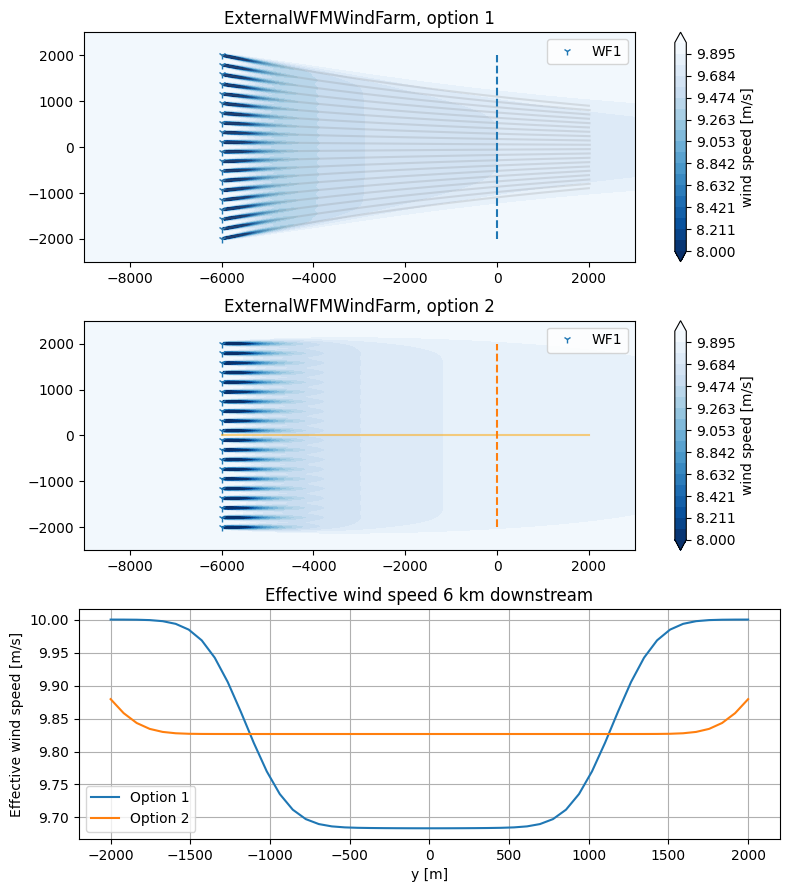

In [56]:
cls = ExternalWFMWindFarm
fig, axes = plt.subplots(3,1,figsize=(8,9))

wf_y = np.linspace(-2000,2000,20)
neighbour_x_y_angle = (wf_y*0-6000, wf_y, 270)

class MyVectorField2(MyVectorField):
    def __call__(self, wd, time, x, y, h):
        return np.array([x*0+1, x*0-y/10000, x * 0]).T
        
site_with_streamlines.distance = StreamlineDistance(MyVectorField2())


for i, (ax, site_setup) in enumerate(zip(axes, [site_with_streamlines, site]), 1):
    ext_farms = setup_ext_farms(cls, [neighbour_x_y_angle], wfm=get_wfm(site=site_setup), include_wd_range=np.array([0]))
    wfm = get_wfm(ext_farms, site=site_with_streamlines)
    sim_res_ext = wfm([],[], type=0, wd=270, ws=10)
    sim_res_ext.flow_map(grid).plot_wake_map(ax=ax, levels=np.linspace(8,10,20))
    
    if site_setup==site_with_streamlines:
        start_points, alpha, c = np.array([ext_farms[0].wt_x, ext_farms[0].wt_y, ext_farms[0].wt_x*0+H]).T, 0.2, 'gray'
    else:
        start_points, alpha, c = np.array([[-6000., 0, 70]]), .5, 'orange'
    stream_lines = vf3d.stream_lines(wd=[270], start_points=start_points, dw_stop=np.full(start_points[:,0].shape, 8000))
    for sl in stream_lines:
        ax.plot(sl[:, 0], sl[:, 1], color=c, alpha=alpha)
    x = np.linspace(-2000,2000)
    fm = sim_res_ext.flow_map(XYGrid(x=0,y=x))
    c = axes[2].plot(x, fm.WS_eff.squeeze(), label=f'Option {i}')[0].get_color()
    ax.plot(x*0, x,'--', color=c)
    setup_plot(ax=ax, axis='scaled', xlabel='', ylabel='', title=f'{cls.__name__}, option {i}', grid=0)
setup_plot(ax=axes[2], xlabel='y [m]', ylabel='Effective wind speed [m/s]', title='Effective wind speed 6 km downstream')